# Exploratory Data Analysis

# 0.0. Imports

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 700)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 0.1. Carregando configurações do arquivo json

In [2]:
stock_dic = {
                1: 'win',
                2: 'wdo',
                3: 'abev3',
                4: 'b3sa3',
                5: 'bbas3',
                6: 'bbdc4',
                7: 'itub4',
                8: 'petr4',
                9: 'vale3'
            }

In [3]:
configs = json.load(open('config_modelo.json', 'r'))
filepath = configs['dataset']['filepath']
filename = configs['dataset']['filename']
horizon = configs['dataset']['horizon']

In [4]:
# Carregar o Dataset
df = pd.read_pickle(filepath+filename)
df.head()

,DATETIME,DATE_1,TIME_1,OPEN_1,HIGH_1,LOW_1,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,DATE_2,TIME_2,OPEN_2,HIGH_2,LOW_2,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,DATE_3,TIME_3,OPEN_3,HIGH_3,LOW_3,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,DATE_4,TIME_4,OPEN_4,HIGH_4,LOW_4,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,DATE_5,TIME_5,OPEN_5,HIGH_5,LOW_5,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,DATE_6,TIME_6,OPEN_6,HIGH_6,LOW_6,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6

## 0.2. Criando coluna target

In [5]:
df['TARGET_WIN'] = df['CLOSE_1'].diff(periods=horizon).shift(-horizon)
df.head(5)

,DATETIME,DATE_1,TIME_1,OPEN_1,HIGH_1,LOW_1,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,DATE_2,TIME_2,OPEN_2,HIGH_2,LOW_2,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,DATE_3,TIME_3,OPEN_3,HIGH_3,LOW_3,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,DATE_4,TIME_4,OPEN_4,HIGH_4,LOW_4,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,DATE_5,TIME_5,OPEN_5,HIGH_5,LOW_5,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,DATE_6,TIME_6,OPEN_6,HIGH_6,LOW_6,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6

In [6]:
df.tail(5)

,DATETIME,DATE_1,TIME_1,OPEN_1,HIGH_1,LOW_1,CLOSE_1,VOL_1,BBANDS_Upper_5_1,BBANDS_Lower_5_1,BBANDS_Upper_10_1,BBANDS_Lower_10_1,BBANDS_Upper_20_1,BBANDS_Lower_20_1,DEMA_20_1,EMA_20_1,MIDPOINT_3_1,MIDPOINT_12_1,MIDPRICE_3_1,MIDPRICE_12_1,SAR_2_1,SAR_6_1,SAR_10_1,SAR_14_1,SAR_18_1,TEMA_5_1,TRIMA_5_1,TRIMA_10_1,TRIMA_20_1,WMA_5_1,WMA_10_1,WMA_20_1,ADX_3_1,ADX_6_1,ADX_10_1,APO_3_12_1,APO_5_12_1,BOP_1,CCI_3_1,CCI_6_1,CCI_12_1,CCI_20_1,MFI_3_1,MFI_6_1,MFI_12_1,MOM_3_1,MOM_6_1,MOM_10_1,MOM_14_1,PPO_3_12_1,PPO_12_20_1,ROC_3_1,ROC_5_1,ROC_7_1,ROC_10_1,RSI_3_1,RSI_6_1,RSI_10_1,RSI_14_1,TRIX_3_1,TRIX_5_1,TRIX_7_1,AD_1,ADOSC_1,OBV_1,ATR_3_1,ATR_6_1,ATR_12_1,ATR_20_1,TRANGE_1,MES_1,DIA_SEMANA_1,SEMANA_DO_ANO_1,DATE_2,TIME_2,OPEN_2,HIGH_2,LOW_2,CLOSE_2,VOL_2,BBANDS_Upper_5_2,BBANDS_Lower_5_2,BBANDS_Upper_10_2,BBANDS_Lower_10_2,BBANDS_Upper_20_2,BBANDS_Lower_20_2,DEMA_20_2,EMA_20_2,MIDPOINT_3_2,MIDPOINT_12_2,MIDPRICE_3_2,MIDPRICE_12_2,SAR_2_2,SAR_6_2,SAR_10_2,SAR_14_2,SAR_18_2,TEMA_5_2,TRIMA_5_2,TRIMA_10_2,TRIMA_20_2,WMA_5_2,WMA_10_2,WMA_20_2,ADX_3_2,ADX_6_2,ADX_10_2,APO_3_12_2,APO_5_12_2,BOP_2,CCI_3_2,CCI_6_2,CCI_12_2,CCI_20_2,MFI_3_2,MFI_6_2,MFI_12_2,MOM_3_2,MOM_6_2,MOM_10_2,MOM_14_2,PPO_3_12_2,PPO_12_20_2,ROC_3_2,ROC_5_2,ROC_7_2,ROC_10_2,RSI_3_2,RSI_6_2,RSI_10_2,RSI_14_2,TRIX_3_2,TRIX_5_2,TRIX_7_2,AD_2,ADOSC_2,OBV_2,ATR_3_2,ATR_6_2,ATR_12_2,ATR_20_2,TRANGE_2,MES_2,DIA_SEMANA_2,SEMANA_DO_ANO_2,DATE_3,TIME_3,OPEN_3,HIGH_3,LOW_3,CLOSE_3,VOL_3,BBANDS_Upper_5_3,BBANDS_Lower_5_3,BBANDS_Upper_10_3,BBANDS_Lower_10_3,BBANDS_Upper_20_3,BBANDS_Lower_20_3,DEMA_20_3,EMA_20_3,MIDPOINT_3_3,MIDPOINT_12_3,MIDPRICE_3_3,MIDPRICE_12_3,SAR_2_3,SAR_6_3,SAR_10_3,SAR_14_3,SAR_18_3,TEMA_5_3,TRIMA_5_3,TRIMA_10_3,TRIMA_20_3,WMA_5_3,WMA_10_3,WMA_20_3,ADX_3_3,ADX_6_3,ADX_10_3,APO_3_12_3,APO_5_12_3,BOP_3,CCI_3_3,CCI_6_3,CCI_12_3,CCI_20_3,MFI_3_3,MFI_6_3,MFI_12_3,MOM_3_3,MOM_6_3,MOM_10_3,MOM_14_3,PPO_3_12_3,PPO_12_20_3,ROC_3_3,ROC_5_3,ROC_7_3,ROC_10_3,RSI_3_3,RSI_6_3,RSI_10_3,RSI_14_3,TRIX_3_3,TRIX_5_3,TRIX_7_3,AD_3,ADOSC_3,OBV_3,ATR_3_3,ATR_6_3,ATR_12_3,ATR_20_3,TRANGE_3,MES_3,DIA_SEMANA_3,SEMANA_DO_ANO_3,DATE_4,TIME_4,OPEN_4,HIGH_4,LOW_4,CLOSE_4,VOL_4,BBANDS_Upper_5_4,BBANDS_Lower_5_4,BBANDS_Upper_10_4,BBANDS_Lower_10_4,BBANDS_Upper_20_4,BBANDS_Lower_20_4,DEMA_20_4,EMA_20_4,MIDPOINT_3_4,MIDPOINT_12_4,MIDPRICE_3_4,MIDPRICE_12_4,SAR_2_4,SAR_6_4,SAR_10_4,SAR_14_4,SAR_18_4,TEMA_5_4,TRIMA_5_4,TRIMA_10_4,TRIMA_20_4,WMA_5_4,WMA_10_4,WMA_20_4,ADX_3_4,ADX_6_4,ADX_10_4,APO_3_12_4,APO_5_12_4,BOP_4,CCI_3_4,CCI_6_4,CCI_12_4,CCI_20_4,MFI_3_4,MFI_6_4,MFI_12_4,MOM_3_4,MOM_6_4,MOM_10_4,MOM_14_4,PPO_3_12_4,PPO_12_20_4,ROC_3_4,ROC_5_4,ROC_7_4,ROC_10_4,RSI_3_4,RSI_6_4,RSI_10_4,RSI_14_4,TRIX_3_4,TRIX_5_4,TRIX_7_4,AD_4,ADOSC_4,OBV_4,ATR_3_4,ATR_6_4,ATR_12_4,ATR_20_4,TRANGE_4,MES_4,DIA_SEMANA_4,SEMANA_DO_ANO_4,DATE_5,TIME_5,OPEN_5,HIGH_5,LOW_5,CLOSE_5,VOL_5,BBANDS_Upper_5_5,BBANDS_Lower_5_5,BBANDS_Upper_10_5,BBANDS_Lower_10_5,BBANDS_Upper_20_5,BBANDS_Lower_20_5,DEMA_20_5,EMA_20_5,MIDPOINT_3_5,MIDPOINT_12_5,MIDPRICE_3_5,MIDPRICE_12_5,SAR_2_5,SAR_6_5,SAR_10_5,SAR_14_5,SAR_18_5,TEMA_5_5,TRIMA_5_5,TRIMA_10_5,TRIMA_20_5,WMA_5_5,WMA_10_5,WMA_20_5,ADX_3_5,ADX_6_5,ADX_10_5,APO_3_12_5,APO_5_12_5,BOP_5,CCI_3_5,CCI_6_5,CCI_12_5,CCI_20_5,MFI_3_5,MFI_6_5,MFI_12_5,MOM_3_5,MOM_6_5,MOM_10_5,MOM_14_5,PPO_3_12_5,PPO_12_20_5,ROC_3_5,ROC_5_5,ROC_7_5,ROC_10_5,RSI_3_5,RSI_6_5,RSI_10_5,RSI_14_5,TRIX_3_5,TRIX_5_5,TRIX_7_5,AD_5,ADOSC_5,OBV_5,ATR_3_5,ATR_6_5,ATR_12_5,ATR_20_5,TRANGE_5,MES_5,DIA_SEMANA_5,SEMANA_DO_ANO_5,DATE_6,TIME_6,OPEN_6,HIGH_6,LOW_6,CLOSE_6,VOL_6,BBANDS_Upper_5_6,BBANDS_Lower_5_6,BBANDS_Upper_10_6,BBANDS_Lower_10_6,BBANDS_Upper_20_6,BBANDS_Lower_20_6,DEMA_20_6,EMA_20_6,MIDPOINT_3_6,MIDPOINT_12_6,MIDPRICE_3_6,MIDPRICE_12_6,SAR_2_6,SAR_6_6,SAR_10_6,SAR_14_6,SAR_18_6,TEMA_5_6,TRIMA_5_6,TRIMA_10_6,TRIMA_20_6,WMA_5_6,WMA_10_6,WMA_20_6,ADX_3_6,ADX_6_6,ADX_10_6,APO_3_12_6,APO_5_12_6,BOP_6,CCI_3_6,CCI_6_6,CCI_12_6,CCI_20_6,MFI_3_6,MFI_6_6,MFI_12_6,MOM_3_6,MOM_6_6,MOM_10_6,MOM_14_6,PPO_3_12_6,PPO_12_20_6

# 1.0. Análise dos Dados

## 1.1. Análise da Correlação entre as Ações

In [7]:
df_close = pd.DataFrame(df['DATETIME'])
df_close.head()

,DATETIME
0,2016-12-22 15:10:00
1,2016-12-22 15:15:00
2,2016-12-22 15:20:00
3,2016-12-22 15:25:00
4,2016-12-22 15:30:00


In [8]:
for n in range( 1, len(stock_dic)+1 ):
    df_close['CLOSE_{}'.format(n)] = df['CLOSE_{}'.format(n)]

df_close.head()

,DATETIME,CLOSE_1,CLOSE_2,CLOSE_3,CLOSE_4,CLOSE_5,CLOSE_6,CLOSE_7,CLOSE_8,CLOSE_9
0,2016-12-22 15:10:00,58075.0,3320.5,14.67,13.97,22.47,14.73,17.04,13.22,23.14
1,2016-12-22 15:15:00,58055.0,3321.0,14.69,13.96,22.48,14.74,17.05,13.18,23.11
2,2016-12-22 15:20:00,58065.0,3318.5,14.68,13.97,22.49,14.73,17.06,13.19,23.08
3,2016-12-22 15:25:00,58105.0,3315.0,14.69,13.98,22.52,14.76,17.08,13.19,23.08
4,2016-12-22 15:30:00,58125.0,3317.0,14.70,14.02,22.55,14.75,17.08,13.16,23.09


In [9]:
# Ajustando o DataFrame para apenas os dados de fechamento
df_corr = df_close.set_index('DATETIME')

df_corr.columns = ['win',
                   'wdo',
                   'abev3',
                   'b3sa3',
                   'bbas3',
                   'bbdc4',
                   'itub4',
                   'petr4',
                   'vale3']

df_corr.head(1)

,win,wdo,abev3,b3sa3,bbas3,bbdc4,itub4,petr4,vale3
DATETIME,,,,,,,,,
2016-12-22 15:10:00,58075.0,3320.5,14.67,13.97,22.47,14.73,17.04,13.22,23.14


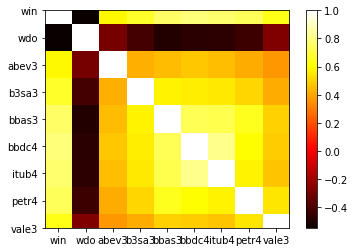

In [10]:
# Criando a matriz de correlação (heatmap)

rets3 = df_corr[:].pct_change()  
corr = rets3.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns);  
plt.savefig("correl.png")  
plt.show()  

Como já esperado, a correlação entre WIN e WDO é negativa.

Além disso, a PETR4 e os bancos ITUB4, BBDC4 e BBAS3 possuem uma correlação forte com o mini índice Bovespa.

Vale ressaltar também que ITUB4 e BBDC4 possuem uma correlação muito forte entre elas.

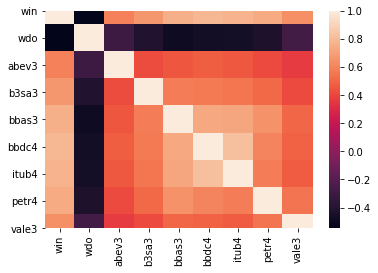

In [11]:
sns_heat = sns.heatmap(corr, 
                xticklabels=corr.columns,
                yticklabels=corr.columns)
plt.savefig("correl_sns.png")

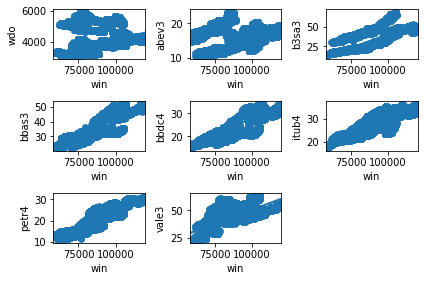

In [12]:
plt.figure(1)
plt.subplot(3,3,1)
sns.regplot(df_corr.win, df_corr.wdo, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,2)
sns.regplot(df_corr.win, df_corr.abev3, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,3)
sns.regplot(df_corr.win, df_corr.b3sa3, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,4)
sns.regplot(df_corr.win, df_corr.bbas3, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,5)
sns.regplot(df_corr.win, df_corr.bbdc4, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,6)
sns.regplot(df_corr.win, df_corr.itub4, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,7)
sns.regplot(df_corr.win, df_corr.petr4, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.subplot(3,3,8)
sns.regplot(df_corr.win, df_corr.vale3, data=df_corr, x_jitter=0.3, fit_reg=True)

plt.tight_layout()

plt.savefig("corr_win_versus_y.png")

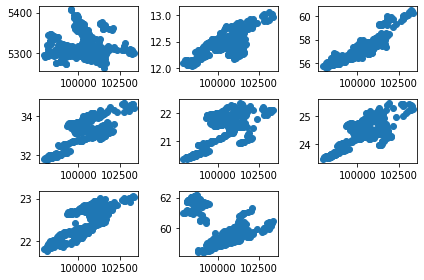

In [13]:
plt.figure(1)
plt.subplot(3,3,1)
plt.scatter(df_corr[-500:].win, df_corr[-500:].wdo)

plt.subplot(3,3,2)
plt.scatter(df_corr[-500:].win, df_corr[-500:].abev3)

plt.subplot(3,3,3)
plt.scatter(df_corr[-500:].win, df_corr[-500:].b3sa3)

plt.subplot(3,3,4)
plt.scatter(df_corr[-500:].win, df_corr[-500:].bbas3)

plt.subplot(3,3,5)
plt.scatter(df_corr[-500:].win, df_corr[-500:].bbdc4)

plt.subplot(3,3,6)
plt.scatter(df_corr[-500:].win, df_corr[-500:].itub4)

plt.subplot(3,3,7)
plt.scatter(df_corr[-500:].win, df_corr[-500:].petr4)

plt.subplot(3,3,8)
plt.scatter(df_corr[-500:].win, df_corr[-500:].vale3)

plt.tight_layout()

## 1.2. Análise da distribuição dos dados

In [14]:
df_buy = df[df['TARGET_WIN'] >= configs['dataset']['buy']]
df_sell = df[df['TARGET_WIN'] <= configs['dataset']['sell']]

Text(0.5, 1.0, 'Vendas/Mês')

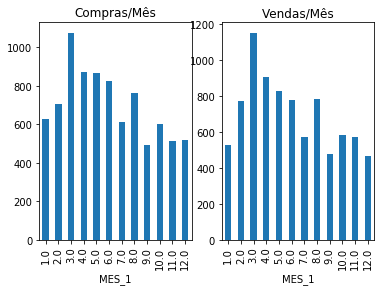

In [15]:
plt.figure(1)
plt.subplot(1,2,1)
df_buy.groupby(['MES_1']).size().plot.bar().set_title('Compras/Mês')
plt.subplot(1,2,2)
df_sell.groupby(['MES_1']).size().plot.bar().set_title('Vendas/Mês')

Text(0.5, 1.0, 'Vendas/Dia da Semana')

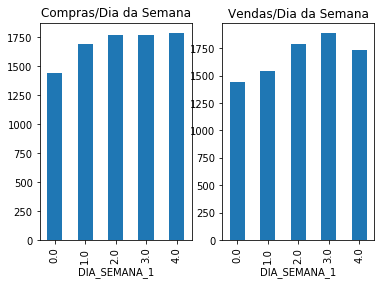

In [16]:
plt.figure(1)
plt.subplot(1,2,1)
df_buy.groupby(['DIA_SEMANA_1']).size().plot.bar().set_title('Compras/Dia da Semana')
plt.subplot(1,2,2)
df_sell.groupby(['DIA_SEMANA_1']).size().plot.bar().set_title('Vendas/Dia da Semana')

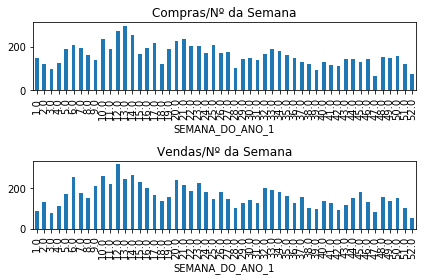

In [17]:
plt.figure(1)
plt.subplot(2,1,1)
df_buy.groupby(['SEMANA_DO_ANO_1']).size().plot.bar().set_title('Compras/Nº da Semana')
plt.subplot(2,1,2)
df_sell.groupby(['SEMANA_DO_ANO_1']).size().plot.bar().set_title('Vendas/Nº da Semana')
plt.tight_layout()

## 2.0. Train Test Split

In [18]:
df_train = df[(df['DATETIME'] < '2019-08-01')]
df_valid = df[(df['DATETIME'] >= '2019-08-01') & (df['DATETIME'] < '2020-01-01')]
df_test  = df[(df['DATETIME'] >= '2020-01-01')]

print(df_train.shape, df_valid.shape, df_test.shape)
print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df['DATETIME'].count()))


(54818, 650) (8897, 650) (14512, 650)
Proporção Train: 70.1% | Validation: 11.4% | Test: 18.6%


# 3.0. Valores Observados

## 3.1. Tendência

## 3.2. Sazonalidade

## 3.3 Aleatoriedade

# Normalizando os Dados

1º Ciclo: Normalizar toda os dados de cada split

2º Ciclo: Normalizar a cada slide window

# Criação da Variável Categórica - Target_Win

# Predictor.ipynb

## Baseline

## Modelo Preditor